In [ ]:
# default_exp examples

# Examples

> Example workflows for using glycowork in your work

In this file, you will access to different examples demonstrating how you can apply `glycowork` to your projects! 
Here is a summary of the different case studies available: <br>

1. [Investigation of *N*-linked and *O*-linked glycosylations in animals](#example1)
2. [Glycan binding specificities of influenza viruses](#example2)
3. [Glycan classification using machine learning models](#example3)
4. [Deep Learning Code Snippet](#example4)

In [ ]:
#hide
from nbdev.showdoc import *
from IPython.display import HTML
import pandas as pd
import copy
import warnings
warnings.filterwarnings("ignore")
from glycowork.glycan_data.loader import df_species, glycan_emb, influenza_binding, df_glycan
from glycowork.motif.analysis import plot_embeddings, make_heatmap, characterize_monosaccharide, get_pvals_motifs
from glycowork.motif.processing import presence_to_matrix
from glycowork.motif.query import get_insight
from glycowork.ml.model_training import train_ml_model, analyze_ml_model, get_mismatch
from glycowork.ml.train_test_split import general_split
%load_ext autoreload
%autoreload 2

# Example 1: Investigation of *N*-linked and *O*-linked glycosylations in animals <a class="anchor" id="example1"></a>

Suppose that after investigating glycans from plants as presented in the `core` module, you are now wondering what happens for glycans from the Animalia kingdom. To satisfy your curiosity, let's start with importing the `df_species` dataset from `glycowork.glycan_data.loader` and putting a filter for animal glycans.

In [ ]:
df_animal = df_species[df_species.Kingdom == 'Animalia'].reset_index(drop = True)

In [ ]:
#hide_input
df_animal2 = copy.deepcopy(df_animal)
df_animal2.index = df_animal2.target.values.tolist()
df_animal2.drop(['target'], axis = 1, inplace = True)
HTML(df_animal2.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref
Fuc(a1-3)[GalNAc(b1-4)]GlcNAc(b1-6)[Gal(b1-3)]GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,nan
Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)[Gal(b1-3)]GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,nan
Fuc(a1-3)[GalNAc(b1-4)]GlcNAc(b1-3)GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,nan
Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-3)GalNAc,Ambystoma_maculatum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,nan
Fuc(a1-2)[Gal(a1-4)]Gal(b1-4)GlcNAc(b1-3)GalNAc,Ambystoma_mexicanum,Ambystoma,Ambystomatidae,Urodela,Amphibia,Chordata,Animalia,Eukarya,nan


To have a better overview of the glycans similarities in animals, you can plot these data using `plot_embeddings` from `glycowork.motif.analysis`. As the number of families in the Animalia kingdom is quite impressive, the best option to visualize the data is to color the dots by taxonomic phyla.  

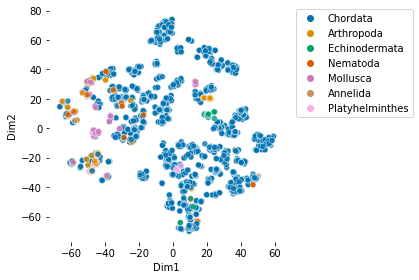

In [ ]:
plot_embeddings(df_animal.target.values.tolist(), label_list = df_animal.Phylum.values.tolist())

With seven phyla, it may be a bit complicated to interpret this graph but the good news is that we can still see some clear glycan clusters! Notably, there is some isolated sets of dark pink dots corresponding to the Mollusca phylum. What is so special about these glycans? Are the observed specificities corresponding to *N*-linked, *O*-linked, or to both types of glycosylations?  <br>

To answer, let's create two datasets to separate *N*-linked and *O*-linked glycosylations. How? By selecting glycans with a **GlcNAc** (*N*-linked) or a **GalNAc** (*O*-linked) monosaccharide at the reducing end. This will help us to identify to which category these isolated clusters correspond to.

In [ ]:
df_N_linked = df_animal[df_animal.target.str.endswith('GlcNAc')]
df_O_linked = df_animal[df_animal.target.str.endswith('GalNAc')]

Everything is ready now. We can perform the plotting step with these two individual datasets.

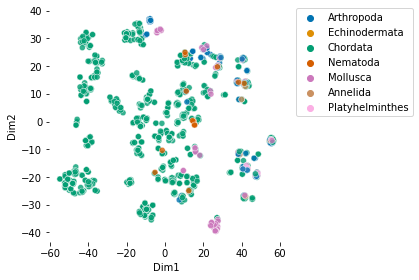

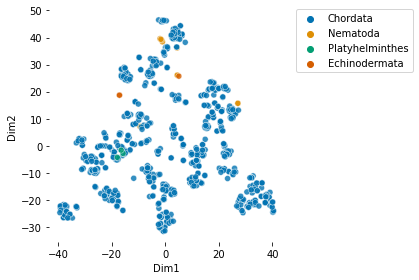

In [ ]:
plot_embeddings(df_N_linked.target.values.tolist(), label_list = df_N_linked.Phylum.values.tolist())
plot_embeddings(df_O_linked.target.values.tolist(), label_list = df_O_linked.Phylum.values.tolist())

Many interesting things to say! First, the *N*-linked glycosylations graph shows the dark pink clusters that we were looking for in addition to some smaller clusters, including one that represents arthropoda glycans (dark blue dots). <br> 

Concerning the second plot, some orange and brown dots are also clustered together and correspond to Nematoda and Echinodermata glycans. Interestingly, this graph also shows the absence of *O*-linked glycans in `df_species` for Arthropoda, Mollusca, and Annelida phyla. <br>

Now, let's focus on Mollusca and their specific *N*-linked glycosylations. We will first convert our data into a count table using `presence_to_matrix` from the `glycowork.motif.processing` module and then visualize the results. A heatmap can be generated using `make_heatmap` from `glycowork.motif.analysis` and the `yticklabels = True` option allows us to display all the labels.

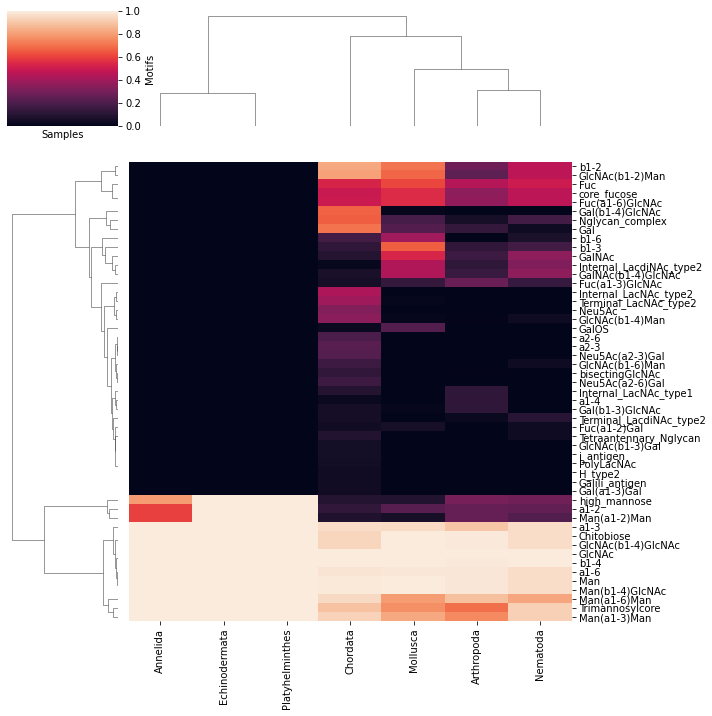

In [ ]:
df_map_N_linked = presence_to_matrix(df_N_linked, label_col_name = 'Phylum')
make_heatmap(df_map_N_linked, mode = 'motif', feature_set = ['known', 'exhaustive'], datatype = 'presence', yticklabels = True)

What an interesting heatmap! The first thing that catches the eye is the absence of a bunch of glycan motifs in the three phyla Annelida, Echinodermata, and Platyhelminthes. Coming back to Mollusca, this heatmap shows for example a relatively high abundance of GalOS (sulfurylated galactose) and b1-3 linkages in these organisms compared to the others. <br>

To visualize which dots from the *N*-linked glycosylations plot correspond to GalOS-containing glycans, we can map them again but with the additional option `shape_feature`. This parameter allows you to transform dots into crosses if the corresponding glycan contains the specified monosaccharide or linkage. 



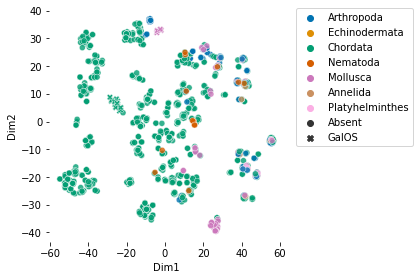

In [ ]:
plot_embeddings(df_N_linked.target.values.tolist(), label_list = df_N_linked.Phylum.values.tolist(), shape_feature = "GalOS")

As you can see, in `df_species`, GalOS-containing glycans exist only in Chordata (green crosses on the left) and Mollusca (dark pink crosses on the top) organisms (in the kingdom Animalia). In this last phylum, they even constitute an isolated cluster. <br> 

As the GalOS monosaccharide displays a singular distribution among animals, we can take a look at its distribution in animal glycans. The `characterize_monosaccharide` from `glycowork.motif.analysis` will be our best ally to learn what are the other monosaccharides to which GalOS is often connected to. <br>

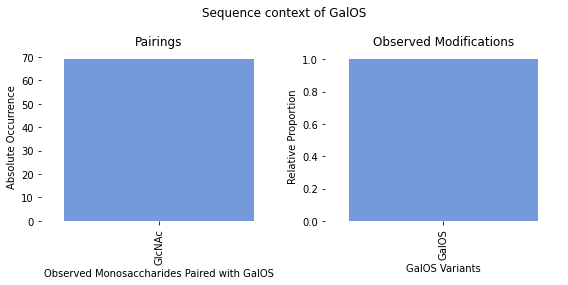

In [ ]:
characterize_monosaccharide('GalOS', rank = 'Kingdom', focus = 'Animalia', modifications = True)

Running this analysis, it appears that GalOS is only found connected to GlcNAc and that it does not display any variant. This is a completely different profile that what was obtained studying xylose in plant glycans! <br>
Let's do one more analysis, in which we turn up the sensitivity of `characterize_monosaccharide` by setting the treshold of observed monosaccharides for the plot to 1.

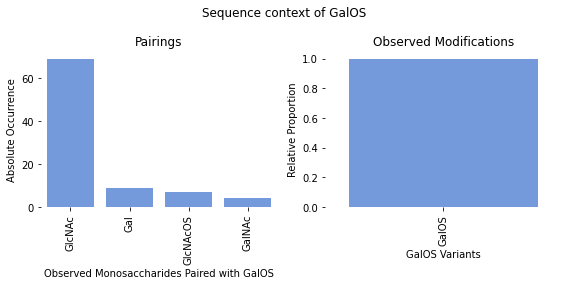

In [ ]:
characterize_monosaccharide('GalOS', rank = 'Kingdom', focus = 'Animalia', modifications = True, thresh = 1)

Interesting, so - quite rarely - sulfurylated galactose in Animalia seems also to be paired with Gal, sulfurylated GlcNAc, and GalNAc! <br>

# Example 2: Glycan binding specificities of influenza viruses <a class="anchor" id="example2"></a>

For this second example, we will move from animals to viruses. Influenza viruses are well known as the biological agents responsible for the seasonal flu in humans. In general, viruses penetrate inside host cells thanks to a mechanism involving contacts between glycosylated proteins. Surface proteins surrounding viruses and eukaryotic cells interact together and allow the entry of viral particules inside the targeted cells. However, different influenza strains may recognize different glycosylations on proteins with more or less efficiency. <br>

To measure these glycan binding specificities, one can add virus particules to glycan arrays presenting immobilized glycans. Such a protocol allows screening for specific binding. From such data, we can then ask what are the glycans that are the most efficiently recognized by a given influenza virus? <br>

Fortunately, `glycowork` can be really helpful to answer such a question! The binding efficiency of different influenza virus strains for a vast range of glycans is available in the `influenza_binding` dataset. Let's start by importing these data.

In [ ]:
#hide_input
HTML(influenza_binding.head().style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica','border-collapse': 'collapse','border': '1px solid black'}).render())

,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,8dNeu5Ac(a2-3)Gal(b1-4)Glc,9dNeu5Ac(a2-3)Gal(b1-4)Glc,Fuc(a1-2)Gal,Fuc(a1-2)Gal(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal,Fuc(a1-2)Gal(b1-3)GalNAc(b1-3)Gal(a1-4)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GalNAc(b1-4)[Neu5Ac(a2-3)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-3)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)GlcNAcOS,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-6)[Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)[Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)]GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-6)GalNAc,Fuc(a1-2)Gal(b1-4)GlcNAcOS,Fuc(a1-2)Gal(b1-4)GlcOS,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-4)]Man(a1-3)[Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)Gal(b1-4)[Fuc(a1-3)]GlcNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)GalNAc,Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Gal(b1-4)Glc,Fuc(a1-2)GalOS(b1-3)GlcNAc,Fuc(a1-2)GalOS(b1-3)GlcNAcOS,Fuc(a1-2)GalOS

As you can see, this dataset contains numerical values (Z-scores) corresponding to the ability of different influenza strains to bind different glycans. From these data, we can compute a heatmap with `make_heatmap`. The results should teach us whether some specific strains bind specific glycans. As we work with quantitative values, the `datatype` parameter must be set to `'response'`. Let's see what kind of heatmap we can generate using this dataset.

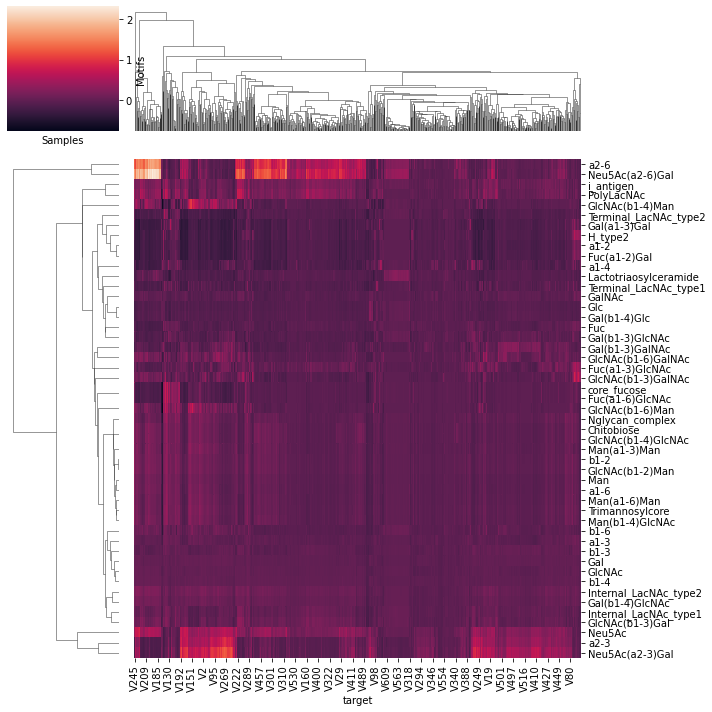

In [ ]:
make_heatmap(influenza_binding, mode = 'motif', feature_set = ['known', 'exhaustive'], datatype = 'response', yticklabels = True)

Due to the high number of viruses in this dataset, the heatmap is difficult to analyze in detail. However, we can clearly see that some specific influenza strains are particularly well suited to recognize specific glycan motifs. Interestingly, we can note that the recognition of a2-6 and Neu5Ac(a2-6)Gal-containing glycans on one hand (two first lines), and the recognition of Neu5Ac, a2-3 and Neu5Ac(a2-3)Gal-containing glycans on the other hand (three last lines) seems to be exclusive in most of the strains. <br>

Another way to analyze the glycan binding capacities of influenza viruses is to use the `get_pvals_motifs` function from the `glycowork.motif.analysis` module. As we are working with data obtained from different strains, we must also set `multiple_samples` to `True`. These adjustments being made, the next step consists in executing the function!

In [ ]:
results = get_pvals_motifs(influenza_binding, feature_set = ['known', 'exhaustive'], multiple_samples = True)

In [ ]:
#hide_input
results = results.applymap(str)
HTML(results[:25].style.set_properties(**{'font-size': '11pt', 'font-family': 'Helvetica',
                                          'border-collapse': 'collapse','border': '1px solid black'}).render())

,motif,pval,corr_pval
23,Internal_LacNAc_type2,0.0,0.0
103,Neu5Ac,0.0,0.0
111,a2-3,0.0,0.0
112,a2-6,0.0,0.0
159,Gal(b1-4)GlcNAc,0.0,0.0
238,Neu5Ac(a2-3)Gal,0.0,0.0
241,Neu5Ac(a2-6)Gal,0.0,0.0
18,i_antigen,9.53871705085845e-194,0.0
30,VIM,7.690771572918131e-181,0.0
117,b1-4,4.671886339472552e-174,0.0


These results indicate, for each motif, a p-value and a corrected p-value. Based on these numbers, we can identify Neu5Ac(a2-3)Gal and Neu5Ac(a2-6)Gal as particularly well recognized motifs. This is consistent with the current knowledge as Neu5Ac(a2-3)Gal is the canonical binding motif for avian influenza and Neu5Ac(a2-6)Gal for mammalian influenza. Interestingly, other motifs also seem to be recognized by influenza strains, such as sulfurylated glycans.

# Example 3: Glycan classification using machine learning models <a class="anchor" id="example3"></a>

Investigation of glycans from animals and viruses demonstrated how specific their presence in an organism can be. This particular characteristic can be exploited to predict the source of a given glycan among living organisms. By classifying which glycans stem from which species/taxonomic groups, machine learning models can be trained to learn which motifs are enriched in which species, allowing further insights. <br>

Let's see how we can use `glycowork` to classify animal versus non-animal glycans! First, we need to annotate each known glycan using a binary code where **1** means **animal glycan** and **0** means **non-animal glycan**. 

In [ ]:
animal = [1 if k == 'Animalia' else 0 for k in df_species.Kingdom.values.tolist()]

Now, we have to generate two sets of glycans that we will use as train set and test set. In addition, we also need their corresponding sets with classes labelled as **0** or **1**. One way to do it is to use the `general_split` function from the `glycowork.ml.train_test_split` module. This function assigns the data with a 80/20 ratio to train and test sets respectively.

In [ ]:
X_train, X_test, y_train, y_test = general_split(df_species.target.values.tolist(), animal)

It is now time to train a machine learning model on these data! Different machine learning algorithms are available in `glycowork` and here we can use the `train_ml_model` function from the `glycowork.ml.model_training` module. This classification method uses a standard machine learning model trained on short glycan motifs which may not be the most accurate, but can be sufficient for a preliminary exploration of our problem. Plus, it has the advantage of running faster than other more complex algorithms such as deep learning so... let's give it a try!

In [ ]:
model_ft, _, X_test = train_ml_model(X_train, X_test, y_train, y_test, feature_calc = True, feature_set = ['exhaustive'],
                         return_features = True)


Calculating Glycan Features...

Training model...
[09:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Evaluating model...
Accuracy of trained model on separate validation set: 0.9579863739591219


As you can see, even this (quite) simple algorithm is enough to reach around 96% prediction accuracy on the test set! It also confirms that glycan composition is highly representative of their origin and allows efficiently discriminating animal from non-animal glycans! <br>

One more step we can do is the analysis of the model we have generated. This is important, as we do not know yet what information is the most useful for this model to predict the origin of a glycan. Fortunately, the `analyze_ml_model` function can help us to understand on which basis the model predictions are made.

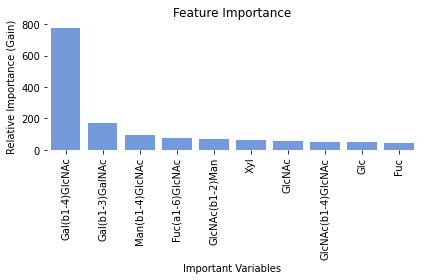

In [ ]:
analyze_ml_model(model_ft)

Interesting! It appears that the presence of the Gal(b1-4)GlcNAc motif in glycans is quite discriminant of its belonging to the Animalia Kingdom! <br>

Next to knowing what is important for model prediction, it is often also crucial to know the limits of a model. In `glycowork`, you can use `get_mismatch` from the `glycowork.ml.model_training` module to get a sense of wrong classifications. This could for instance inform you about potential model biases.

In [ ]:
get_mismatch(model_ft, X_test, y_test)

[('Fuc(a1-2)Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)Glc', 0.9352276921272278),
 ('Man(a1-2)Man(a1-2)Man', 0.007882402278482914),
 ('Fuc(a1-2)Gal(a1-3)Gal(a1-4)Gal(b1-3)GalNAc', 0.3958562910556793),
 ('Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)[Man(a1-2)Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.33273470401763916),
 ('Man(a1-3)[Man(a1-6)][Xyl(b1-2)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.06631074100732803),
 ('Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)[Man(a1-2)Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.33273470401763916),
 ('GlcNAc(b1-2)Man(a1-3)[GlcNAc(b1-4)][GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc',
  0.4787333905696869),
 ('Man(a1-2)Man(a1-2)Man(a1-3)[Man(a1-6)]Man(a1-6)[Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.39137375354766846),
 ('Man(a1-2)Man(a1-3)[Man(a1-2)Man(a1-6)]Man(a1-6)[Man(a1-2)Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.33273470401763916),
 ('Man(a1-2)Man(a1-6)[Man(a1-3)]Man(a1-6)[Man(a1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc',
  0.39137375354766846)]

Here we can see that our model was especially confused by oligo-/high-mannose *N*-linked glycans. The relatively low values indicate that the model thought it rather unlikely that these are animal glycans (remember: anything below 0.5 will default to 'not an animal glycan'). As these mannose-rich structures are also characteristic of fungi such as *Saccharomyces cerevisiae*, classification can be ambiguous. Maybe in these scenarios a more powerful, deep learning-based model might be able to differentiate!

# Deep Learning Code Snippet <a class="anchor" id="example4"></a>

For those of you that are blessed with GPU-access, we wrote up a minimal example for training a glycan-focused deep learning model. Even if you usually do not have access to a GPU, you can always go to Google Colab (click on the badge at the top of this site to open this notebook on Google Colab) and change the runtime type to GPU. Then you can paste the following code in a cell, execute, and see our model train!

First, we need to install torch_geometric for deep learning:

```
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric
```

Then, we import the relevant `glycowork` modules:

```
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import models
from glycowork.ml import model_training
```

Finally, we can prepare the data and train a model to classify from which taxonomic kingdom a glycan came from, using our graph convolutional neural network, `SweetNet`.

```
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = models.prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 100, 0.0005)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)
```

And that's it! You've just trained a state-of-the-art deep learning model with effectively five lines of code (excluding package imports of course).

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_alignment.ipynb.
Converted 02_glycan_data.ipynb.
Converted 03_ml.ipynb.
Converted 04_motif.ipynb.
Converted 05_examples.ipynb.
Converted index.ipynb.
